In [46]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import json
import httpx
import csv
import zstandard as zstd
import io
import yfinance as yf
from dateutil.relativedelta import relativedelta
from httpx import HTTPStatusError
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
# import pandas_ta as ta
from options_data import *

In [101]:
test = GatherData()
print("[1] getting fundamental data")
fundamental_data = test.get_fundamental_data("GOOGL", "2020-01-01", "2025-01-10")
print("[2] getting historical data")
historical_data = test.get_historical_data(["GOOGL"], "2020-01-01", "2025-01-10")

historical_data = pd.DataFrame.rename(historical_data, columns={"root":"ticker"})
historical_data["date"] =pd.to_datetime(historical_data['date'], format='%Y-%m-%d', errors='coerce')
historical_data = historical_data.drop(columns={"underlying_price"})
historical_data = historical_data[historical_data["right"]=="C"]

# fundamental_data["date"] = pd.to_datetime(fundamental_data['date']).dt.date
# historical_data["date"] = pd.to_datetime(historical_data['date']).dt.date

fundamental_data["date"] = pd.to_datetime(fundamental_data['date'])
historical_data["date"] = pd.to_datetime(historical_data['date'])

historical_data["strike"] = historical_data["strike"] / 1000
historical_data = historical_data[historical_data["volume"] > 10]
historical_data = historical_data[(historical_data["date"] > "2022-08-01")]
historical_data = historical_data.rename(columns={"close":"options_close_price", "volume":"options_volume"})
fundamental_data = fundamental_data[(fundamental_data["date"] > "2022-08-01")]
fundamental_data.drop(columns={"close", "high", "low", "open", "volume"}, inplace=True)
fundamental_data.rename(columns={"adjVolume":"stock_traded_volume", "adjClose":"stock_close", "adjHigh":"stock_high", "adjLow":"stock_low", "adjOpen":"stock_open"}, inplace=True)

print('[1] fundamental data')
df = pd.DataFrame(fundamental_data)
print('[2] added historical data')
df = pd.merge(df, historical_data, how="outer", on=["ticker", "date"])
# print('[3] added liquidity data')
# df = pd.merge(df, liquidity_data, how="outer", on=["date"])
# print('[4] added institutional data')
# df = pd.merge(df, institutional_data, how="outer", on=["ticker", "date"])
# print('[5] added sentiment data')
# df = pd.merge(df, sentiment_data, how="outer", on=["ticker", "date"])
# print('[6] added earnings data')
# df = pd.merge(df, earnings_data, how="outer", on=["ticker", "date"])
# df = pd.merge(df, vix_renamed, how="left", on="date")
df = df.drop(columns={"ticker"})

df["expiration"] = df["expiration"].astype(str)
df["expiration"] = pd.to_datetime(df["expiration"], format="%Y-%m-%d", errors="coerce")
print(df["expiration"][df["expiration"].isna()])
# df["expiration"] = pd.to_datetime(historical_data["expiration"], format="%Y-%m-%d", errors="ignore")
# print(df["date"][df["expiration"].isna()])
df["expiration_date"] = df["expiration"]
df["expiration"] = (df["expiration"] - pd.to_datetime(df["date"])).dt.days
df = df.set_index("date")

df = df.drop(columns={"right"})


[1] getting fundamental data
[2] getting historical data
[1] fundamental data
[2] added historical data
Series([], Name: expiration, dtype: datetime64[ns])


In [130]:
# Volatility Calculating from options close price
print(df.columns)

processed_df = df.copy()
# processed_df = processed_df.drop(columns={"high", "low", "stock_close", "open", "adjHigh", "adjLow", "adjOpen"})
processed_df = processed_df[processed_df["options_close_price"] != 0]
# processed_df["implied_vol"] = processed_df["implied_vol"].shift(-1)

processed_df["previous_price"] = processed_df.groupby(["strike", "expiration_date"])["options_close_price"].shift(1)

processed_df["log_return"] = np.log(processed_df["options_close_price"]/processed_df["previous_price"])
# processed_df["log_return"] = processed_df["log_return"].fillna(0)
processed_df["7_day_vol"] = processed_df.groupby(["strike", "expiration_date"])["log_return"].transform(lambda x: x.rolling(window=5).std())
processed_df["7_day_vol_target"] = processed_df.groupby(["strike", "expiration_date"])["7_day_vol"].shift(-5)

processed_df["options_close_price_7_days"] = processed_df.groupby(["strike", "expiration_date"])["options_close_price"].shift(-5)
processed_df["7_day_implied_vol_target"] = processed_df.groupby(["strike", "expiration_date"])["implied_vol"].shift(-5)

processed_df["options_7_day_diff"] = processed_df["options_close_price_7_days"] - processed_df["options_close_price"]
processed_df["implied_forecasted_vol_diff"] = processed_df["implied_vol"] - processed_df["7_day_vol_target"]
processed_df["volatility_ratio"] = processed_df["implied_vol"]/processed_df["7_day_vol_target"]
processed_df["options_overpriced"] = processed_df["implied_forecasted_vol_diff"] > 0

print(processed_df[["expiration_date", "strike"]])

print(processed_df[(processed_df["strike"] == 107) & (processed_df["expiration_date"] == pd.to_datetime("2022-08-12"))][["options_close_price","options_7_day_diff","theta","implied_forecasted_vol_diff",
                                                                                                                             "implied_vol", "7_day_vol_target", "7_day_implied_vol_target", "options_overpriced"]])
# processed_df[["strike", "expiration_date", "options_close_price", "previous_price","log_return","7_day_vol_target"]][1000:]

Index(['stock_close', 'stock_high', 'stock_low', 'stock_open',
       'stock_traded_volume', 'divCash', 'splitFactor', 'expiration', 'strike',
       'options_close_price', 'options_volume', 'count', 'bid', 'bid_size',
       'ask', 'ask_size', 'open_interest', 'delta', 'theta', 'vega', 'rho',
       'epsilon', 'lambda', 'gamma', 'd1', 'd2', 'implied_vol', 'iv_error',
       'expiration_date'],
      dtype='object')
           expiration_date  strike
date                              
2022-08-02      2022-08-12   105.0
2022-08-02      2022-08-12   106.0
2022-08-02      2022-08-12   107.0
2022-08-02      2022-08-26   107.0
2022-08-02      2022-08-12   107.5
...                    ...     ...
2024-12-31      2025-01-03   212.5
2024-12-31      2025-01-17   212.5
2024-12-31      2025-01-03   215.0
2024-12-31      2025-01-17   215.0
2024-12-31      2025-01-17   217.5

[74307 rows x 2 columns]
            options_close_price  options_7_day_diff  theta  \
date                                 

In [140]:
eda = DataVis()
processed_df.dropna(subset = ["7_day_vol_target"], inplace=True)
processed_df = processed_df[processed_df["implied_vol"] != 0]
processed_df = processed_df[processed_df["theta"] != 0]

spearman_correlation_matrix = processed_df.corr(method='spearman')
pearson_correlation_matrix = processed_df.corr(method='pearson')



In [141]:
correlation_price = eda.get_sorted_correlation_pairs(spearman_correlation_matrix, 'options_7_day_target')

print(correlation_price)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation, Abs Correlation]
Index: []


In [142]:
correlation_price[correlation_price["Variable 2"].isin(["implied_vol", "7_day_implied_vol_target","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff", "volatility_ratio", "options_overpriced"])]


,Variable 1,Variable 2,Correlation,Abs Correlation


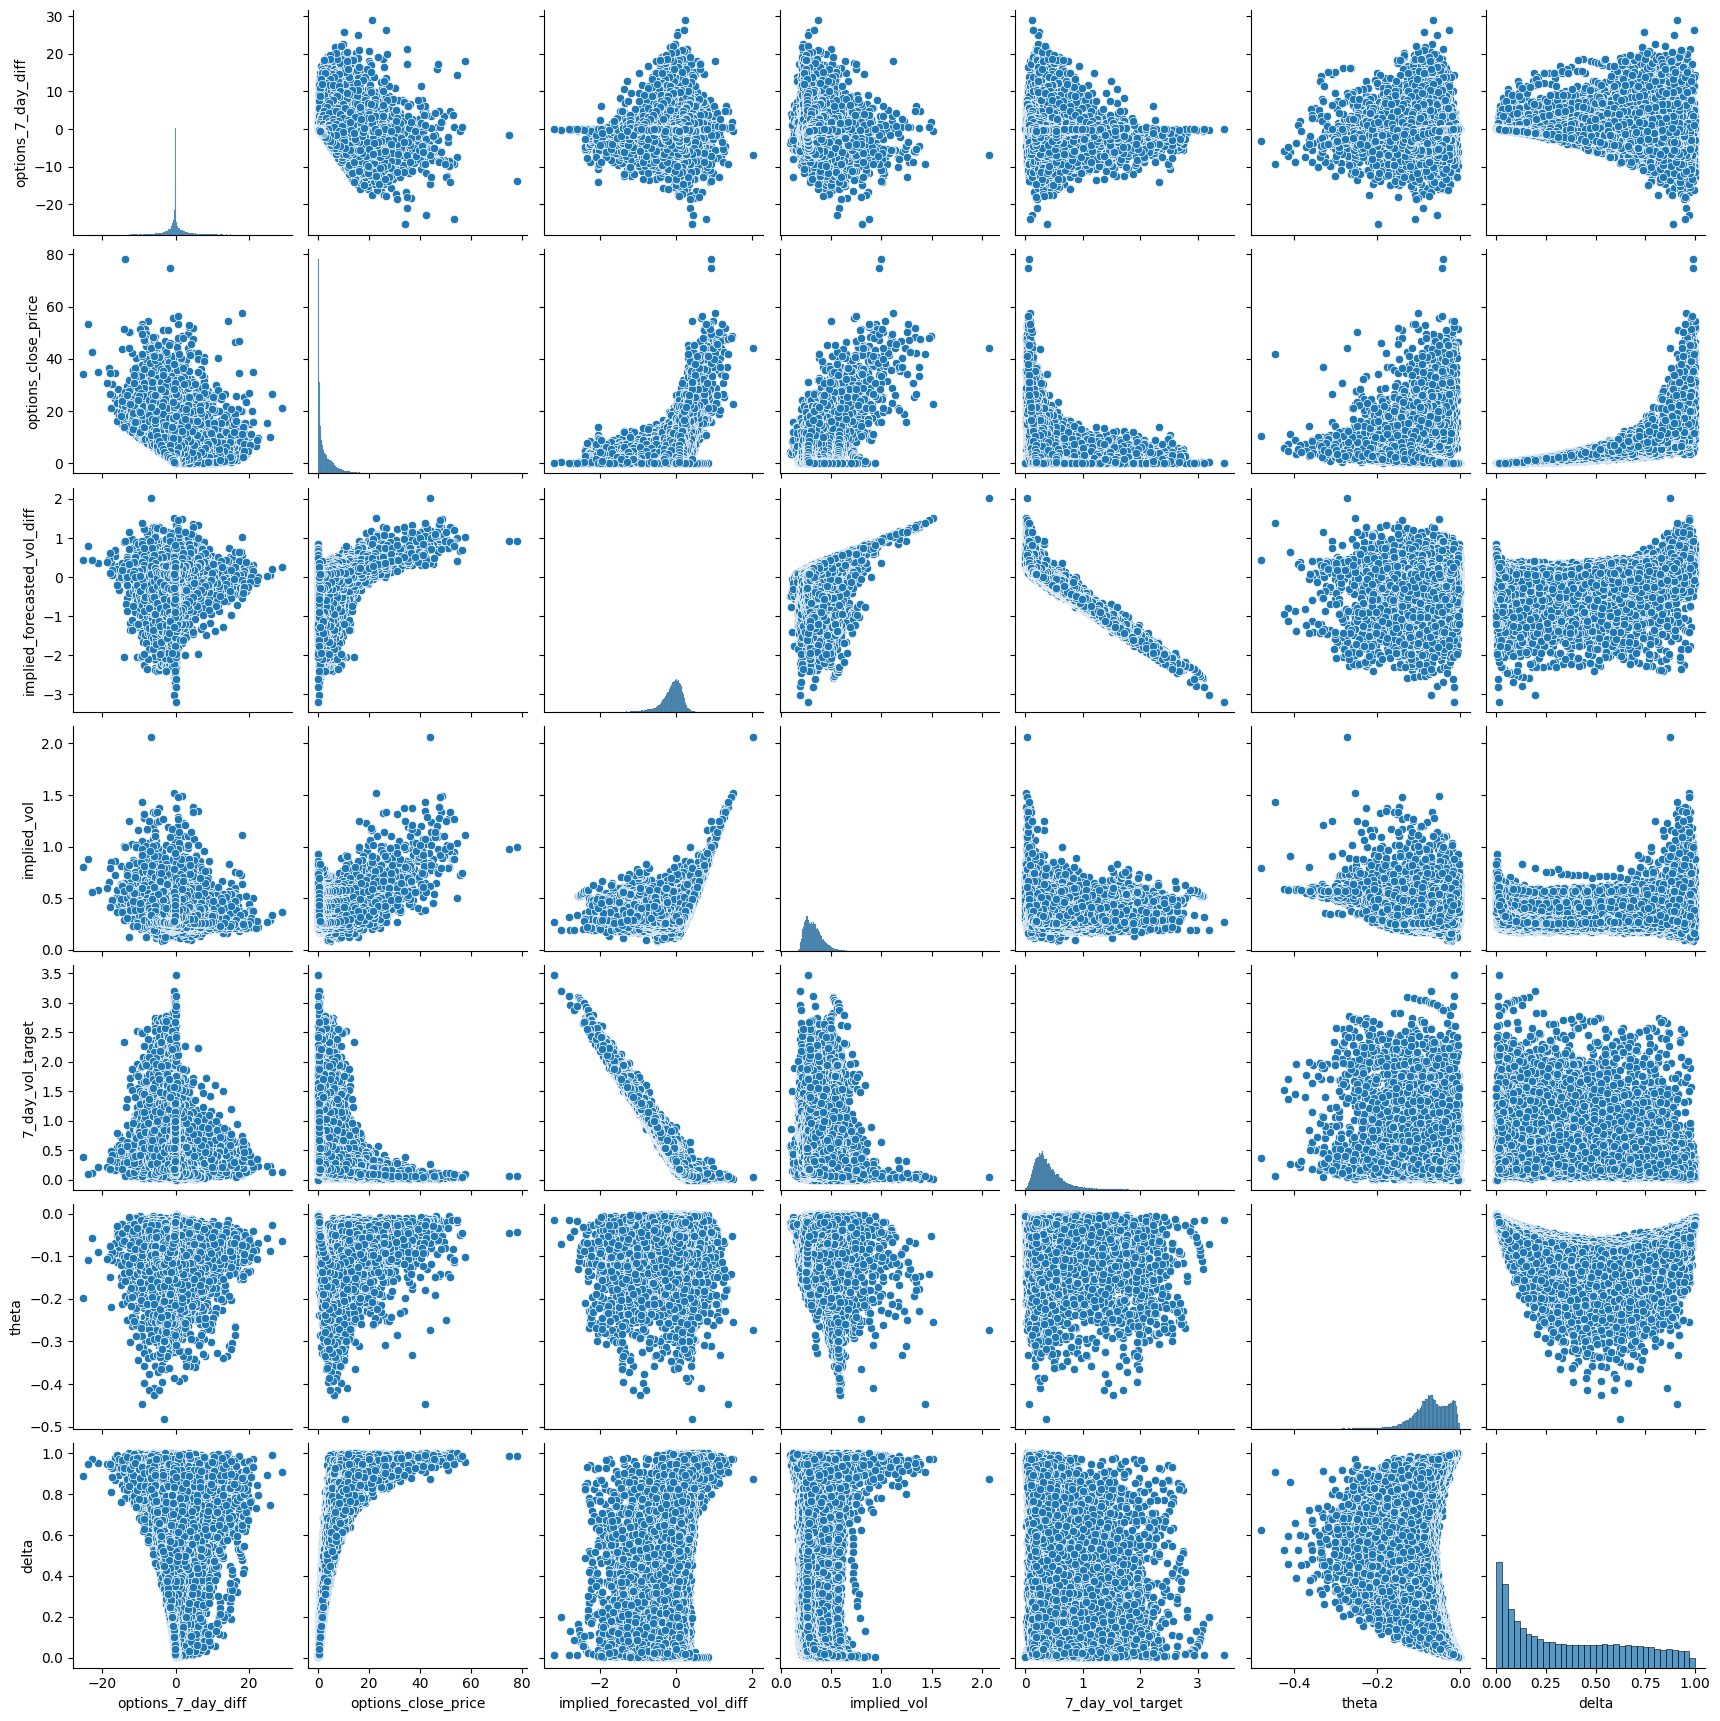

In [143]:
processed_df = processed_df.reset_index(drop=True)
# print(processed_df[["options_7_day_diff", "options_close_price", "implied_forecasted_vol_diff","implied_vol", "7_day_vol_target", "theta","delta"]].columns)
print(sns.pairplot(processed_df[["options_7_day_diff", "options_close_price", "implied_forecasted_vol_diff","implied_vol", "7_day_vol_target", "theta","delta"]]))

<Axes: >

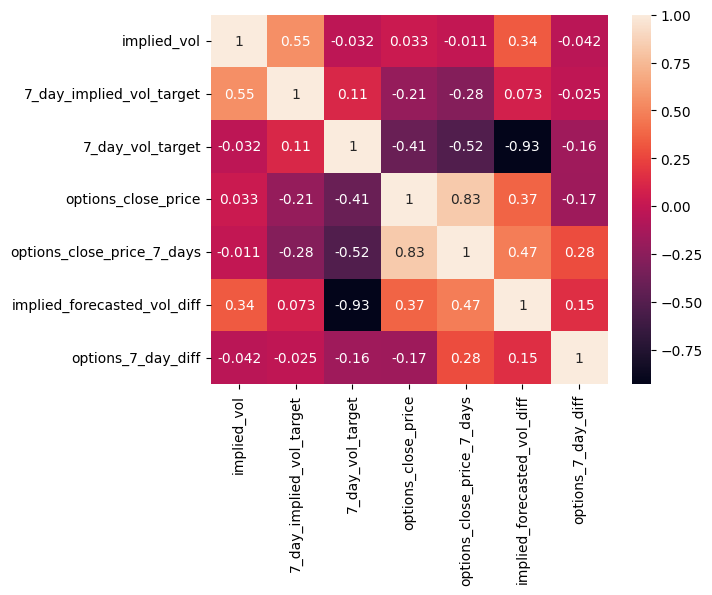

In [145]:
sns.heatmap(processed_df[["implied_vol","7_day_implied_vol_target","7_day_vol_target","options_close_price","options_close_price_7_days","implied_forecasted_vol_diff","options_7_day_diff"]].corr(method='spearman'), annot=True)

In [14]:
# Basic Model (Assuming we have the predicted futures realized_volatility)

